## Model 8: Fine-Tuning on ResNet50
This is my final attempt at fine-tuning model 7 to see if the test accuracy can still improve a bit. It did not work and I did not have the time to look into it.


## Load modules

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.saving import load_model

import helpers
import importlib
importlib.reload(helpers)

from datetime import datetime
def timestamp():
    return datetime.now().strftime('%y%m%d_%H%M')

## Load dataset

In [2]:
# Load CIFAR-10 dataset
x_train, y_train, x_test, y_test = helpers.load_dataset(model='ResNet50')

# augmentate data
datagen = helpers.data_augmentation(x_train)



Loading CIFAR10 dataset
170498071/170498071 [==============================] - 3s 0us/step


## Fine-Tuning
Let's unfreeze all layers and train for another dozen epochs to see if the accuracy improves

In [ ]:
# load best transfer learning model
model_path = f"models/model7_240927_0525.keras"
model_ft = load_model(model_path, safe_mode=False)
# plot results
helpers.evaluate_model(model_ft, x_test, y_test)

In [11]:
# Unfreeze all layers
for layer in model_ft.layers:
    layer.trainable = True

print(model_ft.summary())

# Redefine callbacks
checkpoint = ModelCheckpoint(filepath=f'models/ckp/model7_{timestamp()}.keras', monitor="val_accuracy", save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

model_ft.compile(
    loss='categorical_crossentropy', 
    optimizer=RMSprop(learning_rate=2e-6),  # lower the previous learning rate to avoid damaging the already trained weights
    metrics=['accuracy'])

history = model_ft.fit(
    datagen.flow(x_train, y_train, batch_size=32), 
    epochs=100, 
    validation_data=(x_test, y_test),
    callbacks=[early_stopping, checkpoint, reduce_lr]
)

# save model
model_path = f"models/model7_{timestamp()}.keras"
model_ft.save(model_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 224, 224, None)    0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 batch_normalization (Batch  (None, 100352)            401408    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0

2024-09-27 07:22:30.721685: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9819cdc410 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-09-27 07:22:30.721735: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-09-27 07:22:30.747967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1727421750.853190     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1563/1563 [==============================] - 104s 54ms/step - loss: 0.6555 - accuracy: 0.8405 - val_loss: 0.3449 - val_accuracy: 0.9104 - lr: 2.0000e-06
Epoch 2/100
1563/1563 [==============================] - 83s 53ms/step - loss: 0.4748 - accuracy: 0.8855 - val_loss: 0.2609 - val_accuracy: 0.9310 - lr: 2.0000e-06
Epoch 3/100
1563/1563 [==============================] - 83s 53ms/step - loss: 0.4126 - accuracy: 0.9010 - val_loss: 0.2275 - val_accuracy: 0.9390 - lr: 2.0000e-06
Epoch 4/100
1563/1563 [==============================] - 82s 53ms/step - loss: 0.3788 - accuracy: 0.9082 - val_loss: 0.2006 - val_accuracy: 0.9450 - lr: 2.0000e-06
Epoch 5/100
1563/1563 [==============================] - 82s 53ms/step - loss: 0.3456 - accuracy: 0.9182 - val_loss: 0.1991 - val_accuracy: 0.9460 - lr: 2.0000e-06
Epoch 6/100
1563/1563 [==============================] - 82s 52ms/step - loss: 0.3253 - accuracy: 0.9233 - val_loss: 0.1885 - val_accuracy: 0.9484 - lr: 2.0000e-06
Epoch 7/100
1563/1563 [====

313/313 [==============================] - 6s 16ms/step
Model Loss: 0.15330658853054047
Model Accuracy: 0.9611999988555908
Precision: 0.9611253293768226
Recall: 0.9612
F1-Score: 0.9611108058890715
Accuracy Score: 0.9612


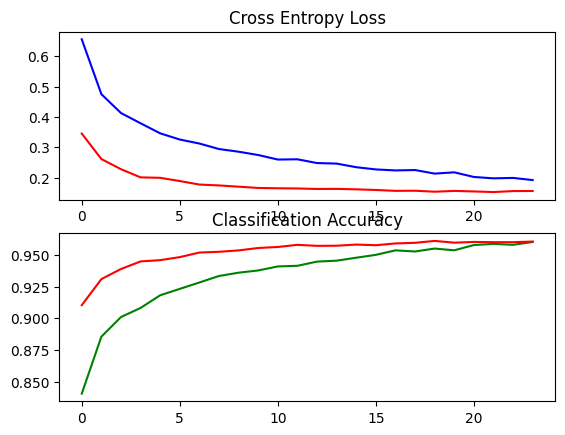

313/313 [==============================] - 5s 16ms/step


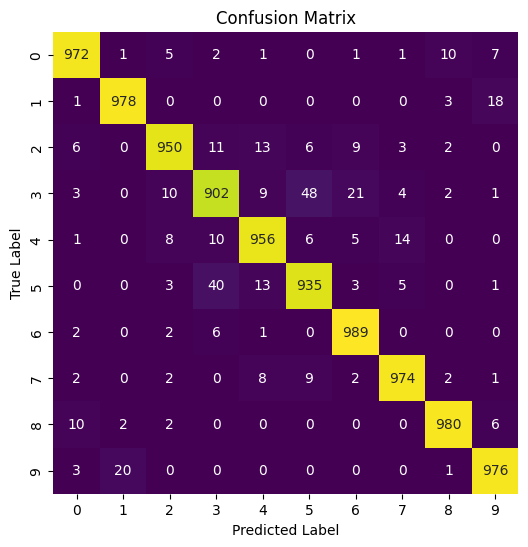

In [5]:
# plot results
helpers.evaluate_model(model_ft, x_test, y_test)
helpers.plot_model_history(history)
helpers.plot_confusion_matrix(model_ft, x_test, y_test)

In [6]:
print(model_path)

models/model7_240927_0756.keras


## Conclusion
The fine-tuning operation initially went well, the model trained for 24 epochs and the final metrics show an improvement of 1% on the accuracy score, now reaching 96%. The confusion matrix itelf shows less misclassifications between cats and dogs.

However, as soon as I loaded the model and tested it on random images, it classifies them completely wrong. Could this be due to leaking, considering that I am re-training the model using the same train and test images. This would give me good results, while the model is actually degrading?

![cats.png](../readme/cats.png)
